In [1]:
# some standard python imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import lenstronomy.Util.util as util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import param_util
from lenstronomy.Util import mask_util
from lenstronomy.Util.util import array2image
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
import numpy as np
import os
import pickle
import copy
import time
import h5py
from pprint import pprint
import joblib
from astropy.cosmology import FlatLambdaCDM
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.LensModel.Profiles.base_profile import LensProfileBase
from lenstronomy.Workflow.fitting_sequence import FittingSequence
import pickle

cwd = os.getcwd()
base_path = cwd
print('Base directory path:', base_path)

Base directory path: /Users/nandinisahu/Library/CloudStorage/OneDrive-UNSW/AGEL/compound_lens/compound_lens_dcls1507-NS-main/notebooks


In [3]:
import matplotlib as mpl

# for MNRAS
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable
import matplotlib.image as mpimg
import seaborn as sns
import coloripy as cp

# to change tex to Times New Roman in mpl
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['mathtext.it'] = 'serif:italic'
plt.rcParams['mathtext.bf'] = 'serif:bold'
plt.rcParams['mathtext.fontset'] = 'custom'


sns.set(style='ticks', context='paper', font='Times New Roman', font_scale=2.)
#sns.set_context('talk')
sns.set_style({"xtick.direction": "in","ytick.direction": "in", "axes.linewidth": 2.0,})
#sns.set_palette('Set2')

cmap = sns.cubehelix_palette(start=0.5, rot=-1.5, gamma=1, hue=1, light=-.6, dark=0.8, reverse=False, as_cmap=True)
cmap2 = sns.cubehelix_palette(start=0.5, rot=-1.5, gamma=1, hue=1, light=-.2, dark=1., reverse=False, as_cmap=True)

msh_cmap = cp.get_msh_cmap(num_bins=501, rescale='power', power=2.5)

/Users/nandinisahu/opt/anaconda3/envs/py3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
import h5py

def import_data(filter_name):
    
    data_file = os.path.join('../data/image_DCLS1507+0522_{}.h5'.format(filter_name))
    f = h5py.File(data_file, 'r')
    
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]
    f.close()

    # get data and PSF estimate from file
    psf_file = os.path.join('../PSF files/psf_model_{}.h5'.format(filter_name))
    f = h5py.File(psf_file, 'r')
    kernel_point_source = f['kernel_point_source'][()]
    # psf_error_map = f['psf_error_map'][()]
    f.close()


    kwargs_psf = {'psf_type': "PIXEL", 
                'kernel_point_source': kernel_point_source ,
                'kernel_point_source_init': kernel_point_source ,
                #    'psf_error_map': psf_error_map,
                }

    return kwargs_data, kwargs_psf

kwargs_data_F200LP, kwargs_psf_F200LP = import_data('F200LP')
kwargs_data_F140W, kwargs_psf_F140W = import_data('F140W')

kwargs_data_F140W['ra_shift'] = kwargs_data_F140W['ra_shift'] - kwargs_data_F200LP['ra_shift']
kwargs_data_F140W['dec_shift'] = kwargs_data_F140W['dec_shift'] - kwargs_data_F200LP['dec_shift']

kwargs_data_F200LP['ra_shift'] = 0
kwargs_data_F200LP['dec_shift'] = 0

In [5]:
# read-in the coordiante system of the exposure
ra_at_xy_0 = kwargs_data_F140W['ra_at_xy_0']
dec_at_xy_0 = kwargs_data_F140W['dec_at_xy_0']
transform_pix2angle = kwargs_data_F140W['transform_pix2angle']
coords_F140W = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)

# read-in the reduced cutout image
data_cutout = kwargs_data_F140W['image_data']
numPix = len(data_cutout)
deltaPix = coords_F140W.pixel_width
print('Pixel size: {:.2f} arcsec'.format(deltaPix))
print('numPix:', numPix)


lens_ra_F140W=  -0.8294023773705237
lens_dec_F140W=-0.4695420413996334
print('Lens center:', lens_ra_F140W, lens_dec_F140W) 

Pixel size: 0.08 arcsec
numPix: 150
Lens center: -0.8294023773705237 -0.4695420413996334


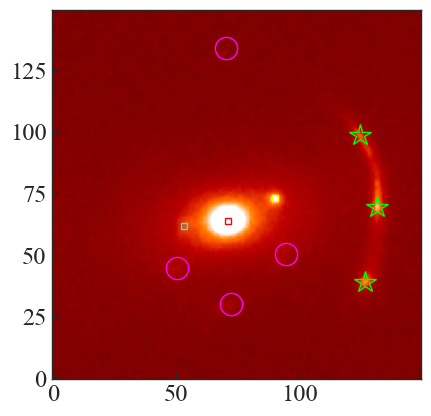

In [6]:
#plot_util.coordinate_arrows(ax, d=120, coords=pixel_grid_F140W, color='red', font_size=0, arrow_size=0.05)
# Plot the modified data

ax = plt.subplot(1,1,1)

shw = ax.imshow(data_cutout, origin='lower', cmap='gist_heat', vmin=-1, vmax=2, aspect=1)

lens_ra_F140W, lens_dec_F140W =-0.8294023773705237, -0.4695420413996334 #113, 102 ,
lens_x_F140W, lens_y_F140W =coords_F140W.map_coord2pix(lens_ra_F140W, lens_dec_F140W )
ax.plot(lens_x_F140W, lens_y_F140W, 's', color='red', markersize=5,mfc='none',label='Lens') 

gal1_ra_F140W, gal1_dec_F140W = -0.39485199683448746, 1.164841851292571
gal1_x_F140W, gal1_y_F140W =coords_F140W.map_coord2pix(gal1_ra_F140W, gal1_dec_F140W)
ax.plot(gal1_x_F140W, gal1_y_F140W, 's', color='yellow',markersize=5,mfc='none', label='Galaxy 1') 

gal2_ra_F140W, gal2_dec_F140W =  -0.7158344298101684, -1.9130777388153974
gal2_x_F140W, gal2_y_F140W =coords_F140W.map_coord2pix(gal2_ra_F140W, gal2_dec_F140W )
ax.plot(gal2_x_F140W, gal2_y_F140W, 's', color='cyan',markersize=5,mfc='none', label='Galaxy 2') 

im_pos_ra_F140W = [1.087777899407675,-1.3006344591144519,-3.6181050419045113,]
im_pos_dec_F140W = [4.260816445991829,4.3514823462042616,3.514645359158428] #
im_pos_x_F140W,im_pos_y_F140W=coords_F140W.map_coord2pix(im_pos_ra_F140W,im_pos_dec_F140W)
ax.plot(im_pos_x_F140W, im_pos_y_F140W, '*', color='lime',markersize=16, mfc='none',label='lensed source 1')

im_pos_ra_s2_F140W=[4.694574513668902, -2.0249943517481808,-3.478016480968383, -2.229425403868929 ]
im_pos_dec_s2_F140W=[0.5189295049084397, -2.4102535789679864,-0.9100397283898605, 1.1561651690498185 ]
im_pos_x_s2_F140W,im_pos_y_s2_F140W=coords_F140W.map_coord2pix(im_pos_ra_s2_F140W,im_pos_dec_s2_F140W)
ax.plot(im_pos_x_s2_F140W, im_pos_y_s2_F140W, 'o', color='magenta', markersize=16, mfc='none', label='lensed source 2')


/var/folders/v5/068qyr6n1v16l5m5qs3sthxm0000gn/T/ipykernel_2675/3967576498.py:78: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(image*mask), origin='lower', cmap=cmap, vmax=1, vmin=-3.5)
/var/folders/v5/068qyr6n1v16l5m5qs3sthxm0000gn/T/ipykernel_2675/3967576498.py:78: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(image*mask), origin='lower', cmap=cmap, vmax=1, vmin=-3.5)
/var/folders/v5/068qyr6n1v16l5m5qs3sthxm0000gn/T/ipykernel_2675/3967576498.py:86: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(image), origin='lower', cmap=cmap, vmax=1, vmin=-3.5)


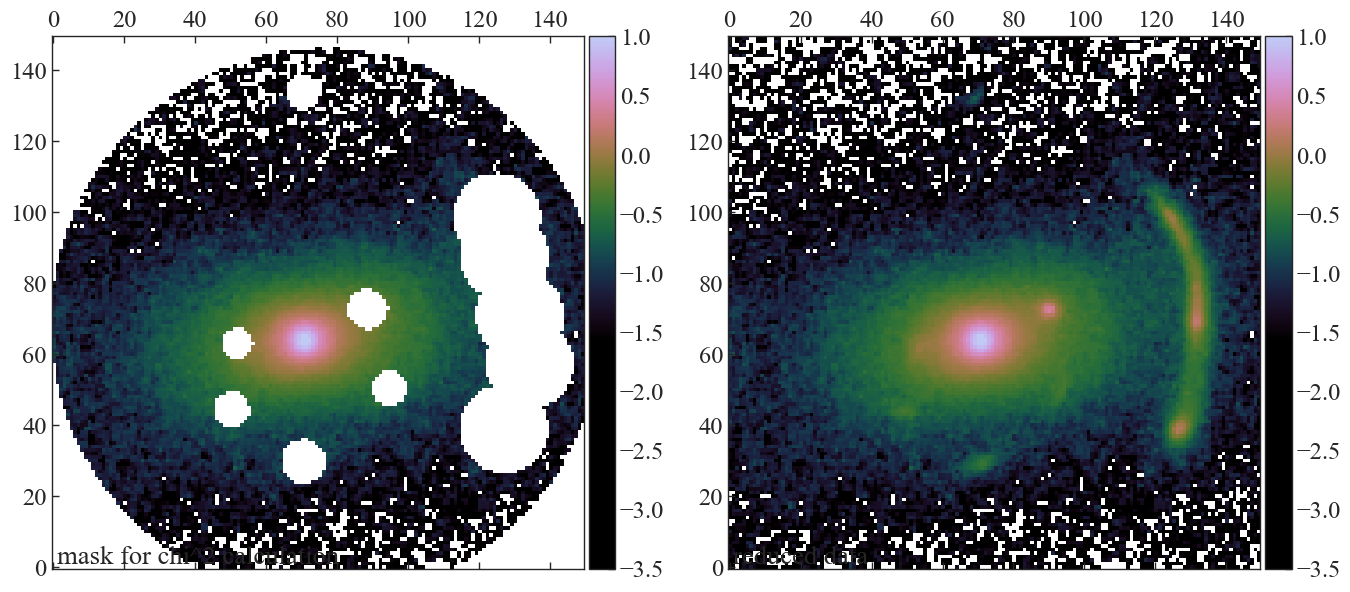

In [7]:
central_mask = True
central_mask_r =0 #0.24 #0.24

#radius of circular aperture to consider 
r_mask_list = [[6.2]
              ]

mask_list = []
index_mask_list = []

for i in range(len(r_mask_list[0])):
    mask_bands = []
    index_mask_bands = []

    for j, kwargs_data in enumerate([kwargs_data_F140W]):
        ra_at_xy_0 = kwargs_data['ra_at_xy_0']
        dec_at_xy_0 = kwargs_data['dec_at_xy_0']
        transform_pix2angle = kwargs_data['transform_pix2angle']
        coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
        num_pix = len(kwargs_data['image_data'])
        lens_center_ra = lens_ra_F140W
        lens_center_dec = lens_dec_F140W

        x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)
        r = r_mask_list[j][i]
        mask_outer = mask_util.mask_center_2d(lens_center_ra+0.3, lens_center_dec+0.5, r, util.image2array(x_coords), util.image2array(y_coords))
        index_mask = 1 - mask_util.mask_center_2d(lens_center_ra, lens_center_dec, r, util.image2array(x_coords), util.image2array(y_coords))
        corona = mask_util.mask_center_2d(lens_center_ra, lens_center_dec, central_mask_r, util.image2array(x_coords), util.image2array(y_coords))
        
        #north perturber 
        mask_np = 1 - mask_util.mask_center_2d(gal1_ra_F140W, gal1_dec_F140W-0.15, 0.45, util.image2array(x_coords), util.image2array(y_coords))
        #southe perturber
        mask_sp = 1 - mask_util.mask_center_2d(gal1_ra_F140W-0.2, gal2_dec_F140W-0.1, 0.35, util.image2array(x_coords), util.image2array(y_coords))
        
        #source 1
        mask_s1_1 = 1 - mask_util.mask_center_2d(im_pos_ra_F140W[0], im_pos_dec_F140W[0], 1, util.image2array(x_coords), util.image2array(y_coords))
        mask_s1_extra1 = 1 - mask_util.mask_center_2d(im_pos_ra_F140W[0]-0.9, im_pos_dec_F140W[0], 1, util.image2array(x_coords), util.image2array(y_coords))
        mask_s1_2 = 1 - mask_util.mask_center_2d(im_pos_ra_F140W[1]+0.1, im_pos_dec_F140W[1], 1, util.image2array(x_coords), util.image2array(y_coords))
        mask_s1_extra2 = 1 - mask_util.mask_center_2d(im_pos_ra_F140W[1]-1, im_pos_dec_F140W[1], 1, util.image2array(x_coords), util.image2array(y_coords))
        mask_s1_3 = 1 - mask_util.mask_center_2d(im_pos_ra_F140W[2], im_pos_dec_F140W[2],1, util.image2array(x_coords), util.image2array(y_coords))

        #source 2
        mask_ext1 = 1 - mask_util.mask_center_2d(im_pos_ra_s2_F140W[0], im_pos_dec_s2_F140W[0], 0.4, util.image2array(x_coords), util.image2array(y_coords))
        mask_ext2 = 1 - mask_util.mask_center_2d(im_pos_ra_s2_F140W[1], im_pos_dec_s2_F140W[1], 0.4, util.image2array(x_coords), util.image2array(y_coords))
        mask_ext3 = 1 - mask_util.mask_center_2d(im_pos_ra_s2_F140W[2], im_pos_dec_s2_F140W[2]-0.15, 0.5, util.image2array(x_coords), util.image2array(y_coords))
        mask_ext4 = 1 - mask_util.mask_center_2d(im_pos_ra_s2_F140W[3], im_pos_dec_s2_F140W[3], 0.4, util.image2array(x_coords), util.image2array(y_coords))

        #mask = (1 - mask_outer) * (1 - mask_ext1) * (1 - mask_ext2) * (1 - mask_ext3) * (1 - mask_ext4)
        mask = (1 - mask_outer) * (1 - mask_ext1) * (1 - mask_ext2) * (1 - mask_ext3) * (1 - mask_ext4)*(1 - mask_np)*(1 -mask_sp )*(1 - mask_s1_1)*(1 - mask_s1_2)*(1 -mask_s1_3 )*(1-mask_s1_extra1)*(1-mask_s1_extra2)
    
        # when modeling both sources    
        #mask = (1 - mask_outer) # now modeling both sources


        if central_mask:
            mask *= corona
        
        # mask = 1 - mask_outer

        mask[mask >= 1] = 1
        mask[mask < 0] = 0
        
        mask_bands.append(array2image(mask))
        index_mask_bands.append(index_mask)
        
    mask_list.append(mask_bands)
    index_mask_list.append(index_mask_bands)
    
for j, kwargs_data in enumerate([kwargs_data_F140W]):
    image = kwargs_data['image_data']
    
    f, axes = plt.subplots(1, len(r_mask_list[0])+1, figsize=(16, 8), sharex=False, sharey=False)
    for i in range(len(r_mask_list[0])):
        ax = axes[i]
        
        mask = mask_list[0][j]
        
        im = ax.matshow(np.log10(image*mask), origin='lower', cmap=cmap, vmax=1, vmin=-3.5)
        ax.text(1, 1, 'mask for chi^2 calculation')
        ax.autoscale(False)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        ax = axes[i+1]
        im = ax.matshow(np.log10(image), origin='lower', cmap=cmap, vmax=1, vmin=-3.5)
        ax.text(1, 1, 'reduced data')
        ax.autoscale(False)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        plt.show()

In [8]:
mask_list[0]

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [9]:
lens_light_model_list = ['SERSIC_ELLIPSE','SERSIC_ELLIPSE']  #,

lightModel = LightModel(lens_light_model_list) 
#lens_light_kwargs = [{'amp': 19.05193231785455, 'R_sersic': 2.9023591993682536, 'n_sersic': 4.664479619045719, 
#                      'e1': -0.2804536135042186, 'e2': -0.024098430671571202, 
#                      'center_x': -0.8061342549499201, 'center_y': -0.48757386212505854}]

#same centre
lens_light_kwargs = [ 
    {'amp': 23.4215295088398, 'R_sersic': 2.6660825376620307, 'n_sersic': 2.1093844144711063, 
     'e1': -0.34236287347714034, 'e2': -0.02481065038820062, 'center_x': -0.8022522397048335, 
     'center_y': -0.485920077450554}, 
    {'amp': 388.55507256414353, 'R_sersic': 0.2936873590416222, 'n_sersic': 1.6435758136274998, 
     'e1': 0.01908035124181226,'e2': -0.014438394531870541, 'center_x': -0.8022522397048335, 
     'center_y': -0.485920077450554}
                      ]


#lens_light_kwargs =[ {'amp': 13.868393563734443, 'R_sersic': 1.1394909083185616, 'n_sersic': 0.680244597852349, 'e1': -0.32654988518363853, 
#                      'e2': -0.02072947436715919, 'center_x': -0.7894669843616212, 'center_y': -0.5487458646076054} ,
#                    {'amp': 110.90861474175799, 'R_sersic': 0.21972491907991742, 'n_sersic': 0.9182335254638719, 'e1': 0.001155537879525203, 
#                     'e2': 0.0018851638268023358, 'center_x': -0.8029586250583903, 'center_y': -0.489340916048151}
#                        ]

chameleon_kwargs = []

kwargs_light = lens_light_kwargs

kwargs_numerics = {'supersampling_factor': 5} #5
kwargs_data=kwargs_data_F140W
kwargs_psf=kwargs_psf_F140W

lens_light_model_list = ['DOUBLE_CHAMELEON'] #'CHAMELEON'  'DOUBLE_CHAMELEON'

kwargs_model = {'lens_light_model_list': lens_light_model_list}
kwargs_constraints = {}
kwargs_numerics_galfit = {'supersampling_factor': 5}
kwargs_likelihood = {'check_bounds': True,
                    'image_likelihood_mask_list':  mask_list[0]}

# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({}) 
#'e11': kwargs_light[0]['e1'], 'e21': kwargs_light[0]['e2'],'e12': kwargs_light[1]['e1'], 'e22': kwargs_light[1]['e2']

#kwargs_chameleon_init = {'w_c': 0.15, 'w_t': 0.003, 
#                         'e1': kwargs_light[0]['e1'], 'e2': kwargs_light[0]['e2'],
#                         'center_x': lens_ra_F814W, 'center_y': lens_dec_F814W} 

#kwargs_lens_light_init.append(kwargs_chameleon_init)

#kwargs_lens_light_sigma.append({'e1': 0.2, 'w_t': 0.2, 'w_c': .1, 'e2': 0.2,
#                                   'center_y': 0.1, 'center_x': 0.1})
#kwargs_lower_lens_light.append({'e1': -0.8, 'e2': -0.7, 'w_t': 0.001, 'w_c': .001,
#                                   'center_y': -10, 'center_x': -10})
#kwargs_upper_lens_light.append({'e1': 0.8, 'e2': 0.7, 'w_t': 10, 'w_c': 10,
#                                               'center_y': 10, 'center_x': 10})

#kwargs_chameleon_init={'ratio': 1.3443841521357003, 'w_c1': 0.07708683592170809, 'w_t1': 0.5027218872292147, 
#                       'e11': -0.08454968355935802, 'e21': 0.0336761857602733, 
#                       'w_c2': 0.17437593330365558, 'w_t2': 5.5893561225978035, 
#                       'e12': -0.43903906210002813, 'e22': -0.05229506908052549, 
#                       'center_x': -0.7955895450486842, 'center_y': -0.47587173823553724}

#kwargs_chameleon_init={'ratio': 0.9898756545476914, 'w_c1': 0.07606501251917679, 'w_t1': 0.3503546630055888, 
#                       'e11': -0.03828606850996896, 'e21': -0.016414123702239398, 
#                       'w_c2': 0.3444015424969858, 'w_t2': 2.963442854859148, 
#                       'e12': -0.3616256326985836, 'e22': -0.01718547191000611, 
#                       'center_x': -0.7989848728058909, 'center_y': -0.47757532752788856}

kwargs_chameleon_init={'ratio': 0.954856265037724, 'w_c1': 0.08181945629597444, 'w_t1': 0.3337317605310567,
  'e11': -0.03000400283453089, 'e21': -0.013779913785008922, 
  'w_c2': 0.32839002025825553, 'w_t2': 2.965007172339426, 
  'e12': -0.36029246627109157, 'e22': -0.017422660059143214, 
  'center_x': -0.7990027746971369, 'center_y': -0.47806017255301964}

kwargs_lens_light_init.append(kwargs_chameleon_init)
kwargs_lens_light_sigma.append({"ratio":0.1,
        "w_c1":0.2,
        "w_t1":0.2,
        "e11":0.2,
        "e21":0.2,
        "w_c2":0.2,
        "w_t2":0.2,
        "e12":0.2,
        "e22":0.2,
        "center_x":0.1,
        "center_y":0.1})
kwargs_lower_lens_light.append({
        "ratio": 0.001,
        "w_c1": 0,
        "w_t1": 0,
        "e11": -0.5,
        "e21": -0.5,
        "w_c2": 0,
        "w_t2": 0,
        "e12": -0.5,
        "e22": -0.5,
        "center_x": -10,
        "center_y": -10,
    })
kwargs_upper_lens_light.append({
    "ratio": 100,
        "w_c1": 10,
        "w_t1": 50,
        "e11": 0.5,
        "e21": 0.5,
        "w_c2": 10,
        "w_t2": 50,
        "e12": 0.5,
        "e22": 0.5,
        "center_x": 10,
        "center_y": 10,
    })

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

kwargs_params = {'lens_light_model': lens_light_params}

image_band = [kwargs_data, kwargs_psf, kwargs_numerics_galfit]
multi_band_list = [image_band]

kwargs_data_joint = {'multi_band_list': multi_band_list,
                         'multi_band_type': 'multi-linear'
                        }

In [18]:
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)
fitting_kwargs_list = [
                      #['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 100}],
                      #['PSO', {'sigma_scale': 0.5, 'n_particles': 100, 'n_iterations': 100}]
                      #['PSO', {'sigma_scale': 0.1, 'n_particles': 100, 'n_iterations': 100}]
                      ['MCMC', {'n_burn': 10, 'n_run': 100, 'walkerRatio': 4, 'sigma_scale': 0.1}]
                      ]

chain_output = fitting_seq.fit_sequence(fitting_kwargs_list)

kwargs_result = fitting_seq.best_fit()

#lens_result = kwargs_result['kwargs_lens']
lens_light_result = kwargs_result['kwargs_lens_light']
#source_resutlt = kwargs_result['kwargs_source']

# Save the chain output and results to a pickle file
output_data = {
    'output': chain_output,
    'kwargs_result': kwargs_result,
}

with open('results_sersic_to_chameleon_1.pkl', 'wb') as f:
    pickle.dump(output_data, f)

print("PSO output and results saved")

MCMC selected. Sampling with default option emcee.


100%|█████████████████████████████████████████| 110/110 [09:26<00:00,  5.15s/it]

Computing the MCMC...
Number of walkers =  44
Burn-in iterations:  10
Sampling iterations (in current run): 110
571.0390799045563 time taken for MCMC sampling
PSO output and results saved


In [10]:
# Load and read the pickle file
def load_pso_results(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

# Example usage
loaded_data = load_pso_results('PSO_results_sersic_to_chameleon.pkl')
print("Loaded keys:", loaded_data.keys())
#print("Lens result:", loaded_data['lens_result'])
#print("Source result:", loaded_data['source_result'])

Loaded keys: dict_keys(['pso_output', 'kwargs_result'])


In [11]:
loaded_data['pso_output'][0][1][1]

[[0.9898756545476914,
  0.07606501251917679,
  0.3503546630055888,
  -0.03828606850996896,
  -0.016414123702239398,
  0.3444015424969858,
  2.963442854859148,
  -0.3616256326985836,
  -0.01718547191000611,
  -0.7989848728058909,
  -0.47757532752788856],
 [0.9898756545476914,
  0.07606501251917679,
  0.3503546630055888,
  -0.03828606850996896,
  -0.016414123702239398,
  0.3444015424969858,
  2.963442854859148,
  -0.3616256326985836,
  -0.01718547191000611,
  -0.7989848728058909,
  -0.47757532752788856],
 [0.9898756545476914,
  0.07606501251917679,
  0.3503546630055888,
  -0.03828606850996896,
  -0.016414123702239398,
  0.3444015424969858,
  2.963442854859148,
  -0.3616256326985836,
  -0.01718547191000611,
  -0.7989848728058909,
  -0.47757532752788856],
 [0.9898756545476914,
  0.07606501251917679,
  0.3503546630055888,
  -0.03828606850996896,
  -0.016414123702239398,
  0.3444015424969858,
  2.963442854859148,
  -0.3616256326985836,
  -0.01718547191000611,
  -0.7989848728058909,
  -0.4775

### for PSO chains

In [14]:
parameter_value_list

[[0.9898756545476914,
  0.07606501251917679,
  0.3503546630055888,
  -0.03828606850996896,
  -0.016414123702239398,
  0.3444015424969858,
  2.963442854859148,
  -0.3616256326985836,
  -0.01718547191000611,
  -0.7989848728058909,
  -0.47757532752788856],
 [0.9898756545476914,
  0.07606501251917679,
  0.3503546630055888,
  -0.03828606850996896,
  -0.016414123702239398,
  0.3444015424969858,
  2.963442854859148,
  -0.3616256326985836,
  -0.01718547191000611,
  -0.7989848728058909,
  -0.47757532752788856],
 [0.9898756545476914,
  0.07606501251917679,
  0.3503546630055888,
  -0.03828606850996896,
  -0.016414123702239398,
  0.3444015424969858,
  2.963442854859148,
  -0.3616256326985836,
  -0.01718547191000611,
  -0.7989848728058909,
  -0.47757532752788856],
 [0.9898756545476914,
  0.07606501251917679,
  0.3503546630055888,
  -0.03828606850996896,
  -0.016414123702239398,
  0.3444015424969858,
  2.963442854859148,
  -0.3616256326985836,
  -0.01718547191000611,
  -0.7989848728058909,
  -0.4775

In [20]:
#for PSO chain
parameter_names=loaded_data['pso_output'][0][2]
parameter_value_list=loaded_data['pso_output'][0][1][1]
#para_mean=np.mean(parameter_value_list, axis=0)
#para_stdev=np.std(parameter_value_list, axis=0)
para_median=np.median(parameter_value_list, axis=0)
print(para_median)
para_16_credible=np.percentile(parameter_value_list, 16.,axis=0)
print(para_16_credible)
para_84_credible=np.percentile(parameter_value_list, 84.,axis=0)
print(para_84_credible)

parameter_fit_uncer_list=loaded_data['pso_output'][0][1][2]
final_para={}
print("lens light parameter median and 68% credible interval")
for i in range(len(parameter_names)):
    final_para['%s'%parameter_names[i]]=(para_median[i], para_84_credible[i],para_16_credible[i])
final_para

[ 0.97597208  0.07984774  0.34133432 -0.03378614 -0.01392539  0.33713301
  2.96583473 -0.36110699 -0.01744849 -0.79900023 -0.47805098]
[ 0.95790954  0.07760142  0.33565862 -0.03624459 -0.01444166  0.32961697
  2.96302214 -0.36176562 -0.01772667 -0.7990871  -0.47816832]
[ 0.98578122  0.0810397   0.34793153 -0.03085566 -0.01350836  0.33983383
  2.97184954 -0.36043367 -0.01723002 -0.79895222 -0.4779399 ]
lens light parameter median and 68% credible interval


{'ratio_lens_light0': (0.9759720819725306,
  0.9857812207658875,
  0.9579095382877646),
 'w_c1_lens_light0': (0.07984773712083361,
  0.08103969587367787,
  0.07760142420096672),
 'w_t1_lens_light0': (0.3413343228250445,
  0.3479315341756664,
  0.33565861674536035),
 'e11_lens_light0': (-0.033786144657136835,
  -0.030855655122396162,
  -0.036244585204790104),
 'e21_lens_light0': (-0.013925385115209554,
  -0.01350835923137167,
  -0.01444165872683329),
 'w_c2_lens_light0': (0.3371330058288847,
  0.3398338324219797,
  0.3296169743304315),
 'w_t2_lens_light0': (2.9658347317592106,
  2.9718495435468593,
  2.963022137194168),
 'e12_lens_light0': (-0.36110699121748824,
  -0.36043367005782617,
  -0.3617656176695922),
 'e22_lens_light0': (-0.017448485761748636,
  -0.017230024490074353,
  -0.017726666513893145),
 'center_x_lens_light0': (-0.7990002295046873,
  -0.7989522209015381,
  -0.7990871001841303),
 'center_y_lens_light0': (-0.4780509763278473,
  -0.4779399018006218,
  -0.47816832237870516)

[ 0.97597208  0.07984774  0.34133432 -0.03378614 -0.01392539  0.33713301
  2.96583473 -0.36110699 -0.01744849 -0.79900023 -0.47805098]
[ 0.95790954  0.07760142  0.33565862 -0.03624459 -0.01444166  0.32961697
  2.96302214 -0.36176562 -0.01772667 -0.7990871  -0.47816832]
[ 0.98578122  0.0810397   0.34793153 -0.03085566 -0.01350836  0.33983383
  2.97184954 -0.36043367 -0.01723002 -0.79895222 -0.4779399 ]


### for mcmc

-0.8872326046748613 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.8872326046748613


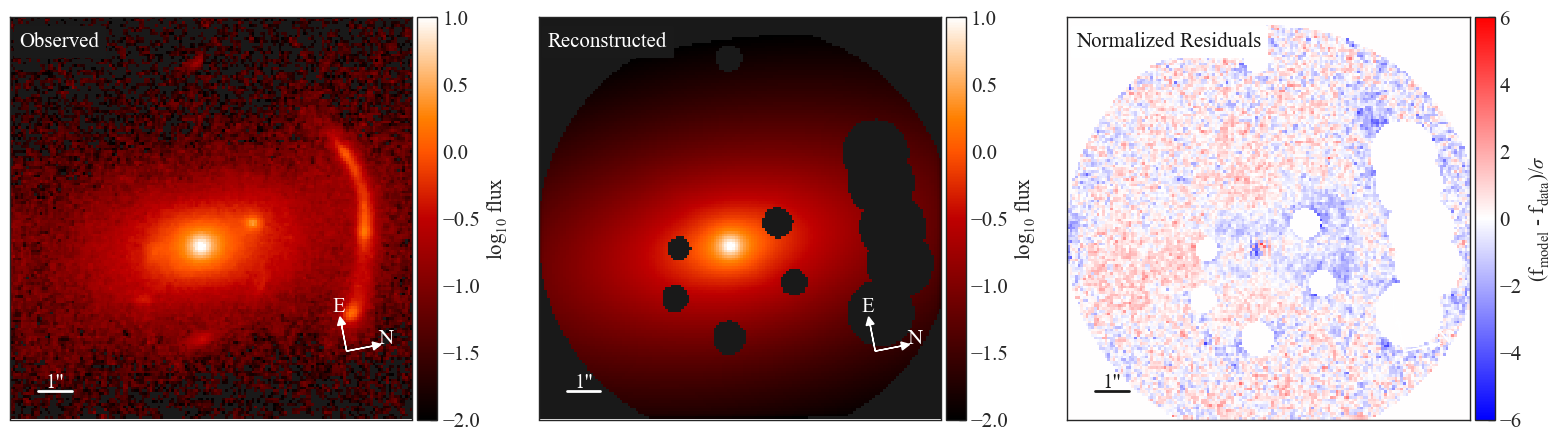

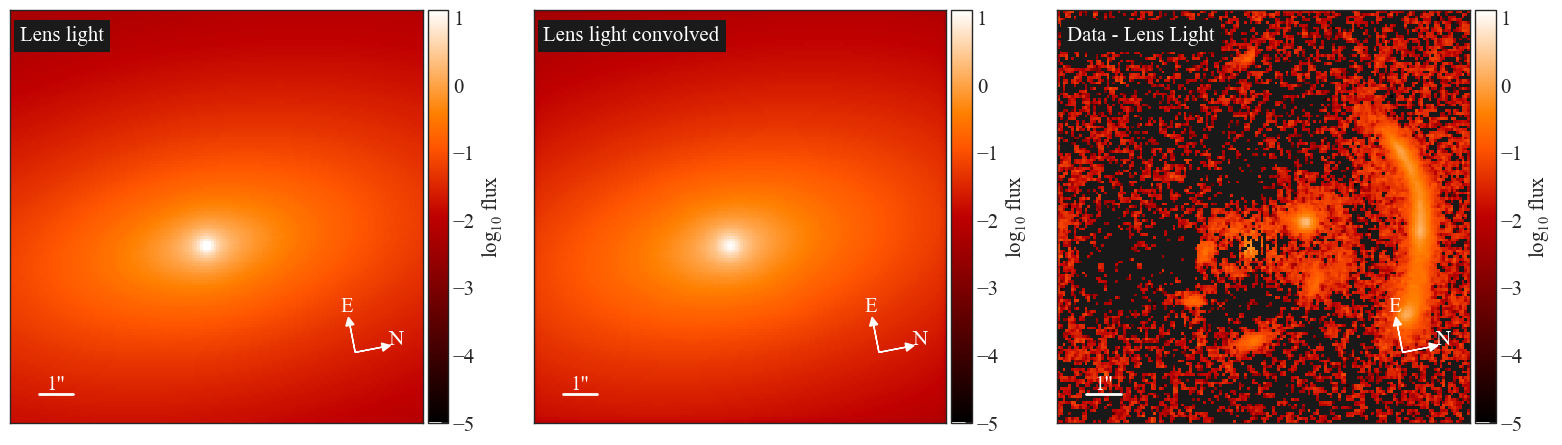

[{'amp': 1, 'ratio': 0.9565544851203073, 'w_c1': 0.08067587622030059, 'w_t1': 0.336042203015477, 'e11': -0.034115328185388115, 'e21': -0.014710528056167934, 'w_c2': 0.3295687730303237, 'w_t2': 2.97079234745559, 'e12': -0.3596963358630191, 'e22': -0.016231234331393524, 'center_x': -0.798539241530556, 'center_y': -0.4775246847768724}]


In [61]:
from lenstronomy.Plots.model_plot import ModelPlot

lens_plot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02,
                      image_likelihood_mask_list=kwargs_likelihood['image_likelihood_mask_list'],
                        multi_band_type='multi-linear'#, source_marg=True, linear_prior=[1e5, 1e5, 1e5]
                        )
f, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)

lens_plot.data_plot(ax=axes[0],v_min=-2, v_max=1)
lens_plot.model_plot(ax=axes[1],v_min=-2, v_max=1)
#lens_plot.absolute_residual_plot(ax=axes[2],v_min=-.1, v_max=0.1)# v_min=-3, v_max=3
lens_plot.normalized_residual_plot(ax=axes[2],v_min=-6, v_max=6)
f.tight_layout()
plt.show()

f, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)

lens_plot.decomposition_plot(ax=axes[0], text='Lens light', lens_light_add=True, unconvolved=True)
lens_plot.decomposition_plot(ax=axes[1], text='Lens light convolved', lens_light_add=True)
lens_plot.subtract_from_data_plot(ax=axes[2], text='Data - Lens Light', lens_light_add=True)
f.tight_layout()
plt.show()

print(lens_light_result)
chameleon_kwargs.append(lens_light_result[0])